In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import gaussian_kde
import sqlalchemy as sa


import snmcseq_utils
from snmcseq_utils import create_logger
from snmcseq_utils import plot_tsne_values 
from __init__ import *




In [2]:
print(pd.__version__)

0.20.3


# Cells QC:

> - Exclude reads with poor mapping (MAPQ < 30)
- Exclude cells with high methylation (>2%) averaged across all CCC positions in the genome.
- Exclude cells with low coverage (<XX%)
- Exclude cells with low mapping rate (<XX%)
- ...


### conclusion:
- remove mCCC/CCC > 2%
- mapping rate < 4% 
- remove % genome covered < 4% and > 20%



In [2]:
# 3C sample bin
ens = 'Ens1'
context = 'CH'
bin_size = BIN_SIZE_FEATURE
ens_path = os.path.join(PATH_ENSEMBLES, ens)
input_f = os.path.join(ens_path, 'binc_m{}_{}_QC_cells_covr_{}.tsv'.format(context, bin_size, ens))
fcells = pd.read_table(input_f, index_col='sample')

print(fcells.shape)
fcells.head()

(1202, 2)


,covr_before,covr_after
sample,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD001_indexed,0.949637,0.985270
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD002_indexed,0.961923,0.996072
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD004_indexed,0.960785,0.994010
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD007_indexed,0.958234,0.992340
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_A10_AD008_indexed,0.961884,0.997398


In [3]:
# mapping summary of 

f_meta = os.path.join(PATH_ENSEMBLES, '{}/mapping_summary_{}.tsv'.format(ens, ens)) 
df_meta = pd.read_table(f_meta, index_col='Sample')
df_meta = pd.merge(df_meta, fcells, left_index=True, right_index=True, how='left')
print(df_meta.shape)
df_meta.head()

(1202, 16)


,Total reads,Mapped reads,Mapping rate,Nonclonal reads,% Nonclonal rate,Filtered reads,Filtered rate,Lambda mC/C,mCCC/CCC,mCG/CG,mCH/CH,Estimated mCG/CG,Estimated mCH/CH,% Genome covered,covr_before,covr_after
Sample,,,,,,,,,,,,,,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed,2279422,1443850,0.633,941772,0.652,819822,0.871,0.00,0.00789,0.76195,0.02756,0.76006,0.01983,3.36,0.514936,0.555141
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G4_AD008_indexed,4252158,2826725,0.665,2184223,0.773,1747325,0.800,NaN,0.00773,0.76572,0.02803,0.76389,0.02046,7.17,0.960353,0.992537
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C3_AD002_indexed,3649262,2447983,0.671,1887885,0.771,1629253,0.863,0.75,0.00856,0.77589,0.03182,0.77396,0.02346,6.77,0.967026,0.999902
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H3_AD002_indexed,4386850,2943685,0.671,2301085,0.782,1959547,0.852,NaN,0.00818,0.77278,0.02875,0.77091,0.02074,8.04,0.967890,0.999951
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B7_AD002_indexed,3861170,2568841,0.665,1870749,0.728,1594420,0.852,NaN,0.00759,0.76714,0.02690,0.76536,0.01946,6.59,0.964396,0.997790


In [4]:
def scatter_color_by_density(ax, x, y, rescale='log10', **kwargs):
    """
    """
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
        
    if rescale == None:
        ax.scatter(x, y, c=z, edgecolor='', **kwargs)
    elif rescale == 'log10':
        ax.scatter(x, y, c=np.log10(z), edgecolor='', **kwargs)
    
    return
    


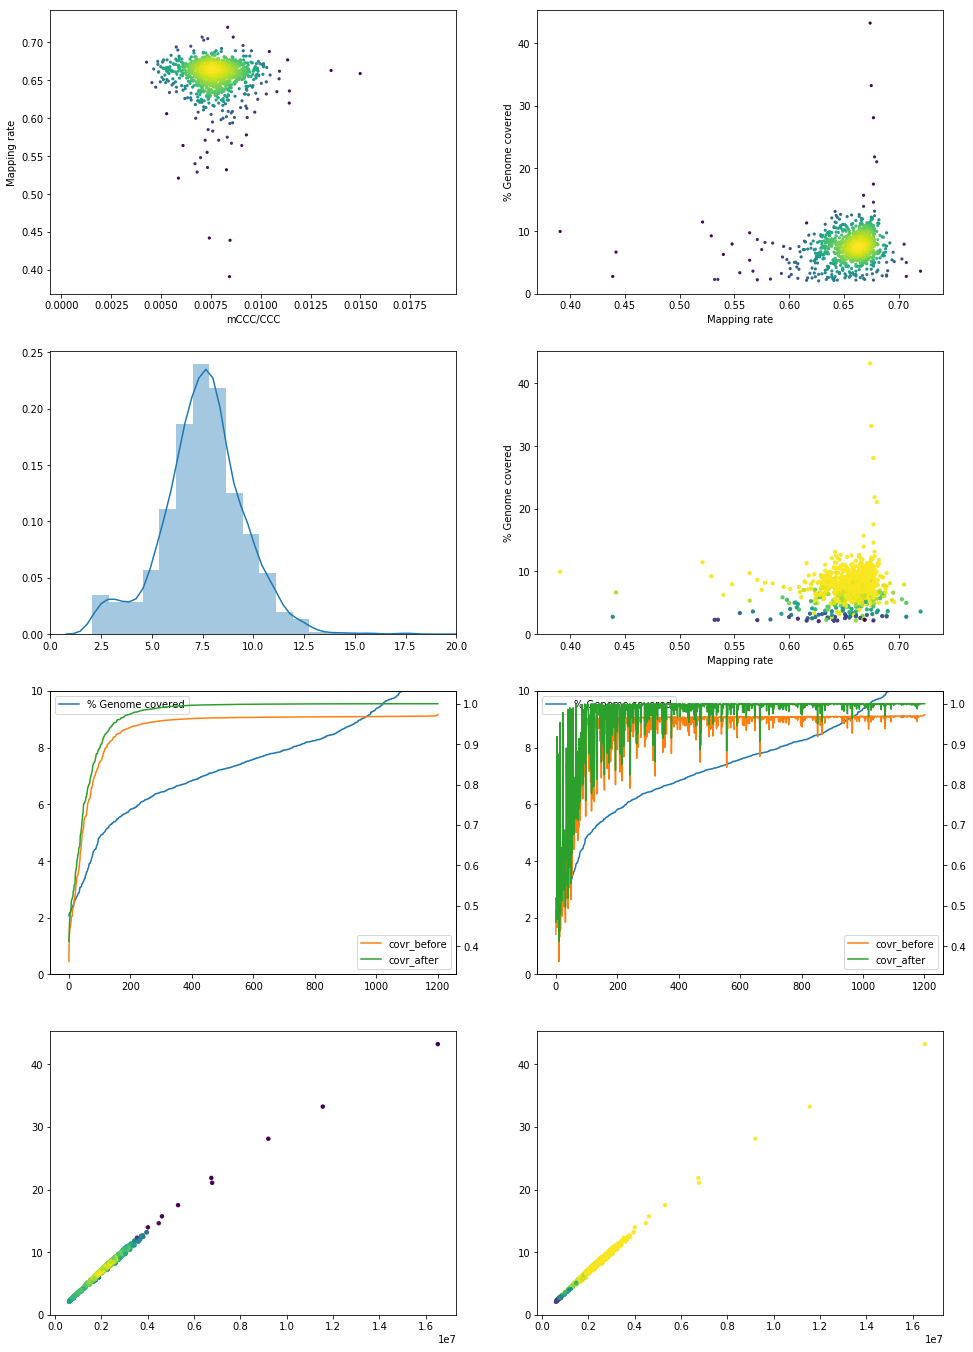

In [14]:
fig, axs = plt.subplots(4, 2, figsize=(16, 24))
ax = axs[0, 0]
scatter_color_by_density(ax, df_meta['mCCC/CCC'], df_meta['Mapping rate'], s=10)
ax.set_xlabel('mCCC/CCC')
ax.set_ylabel('Mapping rate')
ax = axs[0, 1]
scatter_color_by_density(ax, df_meta['Mapping rate'], df_meta['% Genome covered'], s=10)
ax.set_xlabel('Mapping rate')
ax.set_ylabel('% Genome covered')
ax = axs[1, 0]
# ax.plot(df_meta['% Genome covered'].sort_values().values)
# ax.set_ylim([0, 10])
sns.distplot(df_meta['% Genome covered'].values, ax=ax)
ax.set_xlim([0, 20])
ax = axs[1, 1]
ax.scatter(df_meta['Mapping rate'], df_meta['% Genome covered'], c=df_meta['covr_before'], s=10)
ax.set_xlabel('Mapping rate')
ax.set_ylabel('% Genome covered')
ax = axs[2, 0]
ax.plot(df_meta['% Genome covered'].sort_values().values, label='% Genome covered')
ax.set_ylim([0, 10])
ax2 = ax.twinx()
ax2.plot(df_meta['covr_before'].sort_values().values, label='covr_before', color='C1')
ax2.plot(df_meta['covr_after'].sort_values().values, label='covr_after', color='C2')
ax.legend()
ax2.legend()
ax = axs[2, 1]
ax.plot(df_meta.sort_values('% Genome covered')['% Genome covered'].values, label='% Genome covered')
ax.set_ylim([0, 10])
ax2 = ax.twinx()
ax2.plot(df_meta.sort_values('% Genome covered')['covr_before'].values, label='covr_before', color='C1')
ax2.plot(df_meta.sort_values('% Genome covered')['covr_after'].values, label='covr_after', color='C2')
ax.legend()
ax2.legend()

ax = axs[3, 0]
scatter_color_by_density(ax, df_meta['Nonclonal reads'], df_meta['% Genome covered'], s=20)
ax = axs[3, 1]
ax.scatter(df_meta['Nonclonal reads'], df_meta['% Genome covered'], c=df_meta['covr_before'], s=10)

plt.show()

In [64]:

f_tsne = os.path.join(ens_path, 'tsne_cluster_Ens1_test1.tsv')
df_tsne = pd.read_table(f_tsne, index_col='sample')
print(df_tsne.shape)
df_tsne.head()

(1202, 3)


,tsne_x,tsne_y,cluster_ID
sample,,,
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_A11_AD002_indexed,-3.155470,-7.326878,cluster_9
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_G4_AD008_indexed,0.317423,-25.495892,cluster_3
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_C3_AD002_indexed,-10.937735,46.480380,cluster_12
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_1_CEMBA171206_3C_3_H3_AD002_indexed,-24.195724,16.930975,cluster_8
171213_CEMBA_mm_P56_P63_3C_MOp_CEMBA171206_3C_4_CEMBA171206_3C_5_B7_AD002_indexed,2.791611,-44.071790,cluster_4


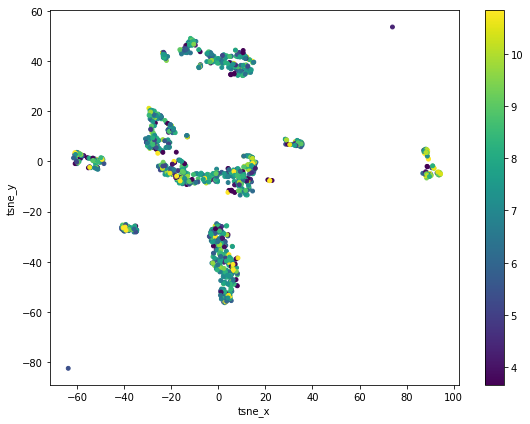

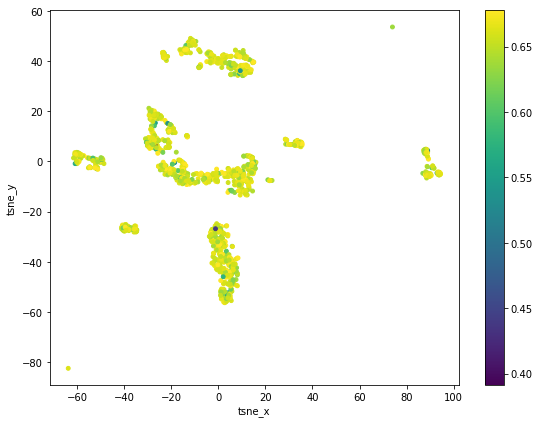

In [46]:
# where those cells are in tsne plot (high coverage?)
df_plot = pd.merge(df_meta, df_tsne, left_index=True, right_index=True)
plot_tsne_values(df_plot, tc='% Genome covered', low_p=5, hi_p=95, s=15)

df_plot = pd.merge(df_meta, df_tsne, left_index=True, right_index=True)
plot_tsne_values(df_plot, tc='Mapping rate', low_p=0, hi_p=95, s=15)